This is your final assignment. You'll get a lot of freedom in doing this assignment but that also means you have to make choices and explain the reasoning behind those choices in your report.

For this assignment you can use any dataset you can find from the Our World in Data website.

# **Q1: What is the biggest predictor of a large CO₂ output per capita of a country**?

To determine this you may want to consider things like GDP per capita, diets, number of cars per capita, various energy source, mobility and other factors.

Your answer can also be a specific combination of certain factors.


## **Data preparation**

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy import stats
# %load_ext google.colab.data_table

###Functions used

In [2]:
# Function for cleaning data
def print_separator(sep, num, msg):
  print("\n")
  print(sep * num)
  print(f"{msg}")
  print(sep * num)


def look_at_unique_values(column):
  unique_values_cutoff = 150  # Mocht je de hele lijst willen zien, dan 50 veranderen in bijv 160 of 260
    # Het gekke is dat het mij wel lukt om de lijst te sorteren bij kolom: "q4-country"
    # Met:
    # sorted = df.loc[:,'q4-country'].sort_values()
    # sorted.unique()
  unique_values = column.unique()
  num_unique_values = len(unique_values)
  if num_unique_values == len(column):
    print(f"Each value in the column is unique (total: {num_unique_values})")
  elif num_unique_values < unique_values_cutoff:
    print(f"Less than {unique_values_cutoff} unique values (total: {num_unique_values}):")
    # We may get an error when sorting
    try:
      sorted = np.sort(unique_values) # Op stack overflow staat dat .sort verouderd is: deze regel oorspronkelijk
      # sorted = df.loc[:, 'q4-country'].sort_values() # Er zelf bij gemaakt, weet niet hoe je de kolom generiek maakt
      # sorted.unique() # Er zelf bij gemaakt
      print("Values are sorted")
      # display(list(sorted.unique())) # Oorspronkelijk zonder .unique() Dit geeft de lijst op elke regel een nieuw land
      display(sorted.unique()) # Er zelf bij gemaakt Dit geeft de lijst met op elke regel meerdere landen, compacter
    except:
      print("Could not sort values")
      display(list(unique_values))
  else:
    print(f"More than {unique_values_cutoff} unique values (total: {num_unique_values})")


def look_at_edges(df, column_name):
  # inner function
  def show_head_and_tail(values):
      num_items_to_slice = 10
      display(list(values)[:num_items_to_slice])
      display(list(values)[-num_items_to_slice:])

  column = df[column_name]
  unique_values = column.unique()
  try:
      sorted = np.sort(unique_values)
      print("Unique values sorted, head and tail:")
      show_head_and_tail(sorted)
  except TypeError as error:
      print(f"Could not sort values: {error}")
      print("..so let's try filtering NULL values and then sorting")
      non_null_uniques = df.loc[~df[column_name].isnull(), column_name].unique()
      sorted = np.sort(non_null_uniques)
      show_head_and_tail(sorted)


def cast_to_type(column, maybe_type):
  try:
    column.astype(maybe_type)
    print(f"Casting to {maybe_type} was successful")
  except ValueError as error:
    print(f"Could not cast to {maybe_type}: {error}")


def find_non_default_missing_values(df, column_name, maybe_type):
  long_separator_amount = 80
  short_separator_amount = 40

  print_separator("*", long_separator_amount, f"Finding non default missing values for column \"{column_name}\"")

  print(f"Column \"{column_name}\" has datatype: {df.dtypes[column_name]}")

  column = df[column_name]

  # A
  print_separator("-", short_separator_amount, "A: Looking at unique values")
  look_at_unique_values(column)

  # B
  print_separator("-", short_separator_amount, "B: Sorting and looking at the edges")
  look_at_edges(df, column_name)

  # C
  print_separator("-", short_separator_amount, f"C: Casting to type: {maybe_type}")
  cast_to_type(column, maybe_type)

  # D
  print_separator("-", short_separator_amount, "D: Looking at frequency")
  display(column.value_counts(dropna=False))

  print("\n")

In [3]:
# function to calculate pierson correlationcoeffiecient for each pairwise column
# reference: https://www.statology.org/p-value-correlation-pandas/
def r_pierson_corr_coef(df):
    cols = pd.DataFrame(columns=df.columns)
    coco = cols.transpose().join(cols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            coco[r][c] = round(pearsonr(tmp[r], tmp[c])[0], 4)
    return coco

# function to calculate p-values for each pairwise column
# reference: https://www.statology.org/p-value-correlation-pandas/
def r_pvalues(df):
    cols = pd.DataFrame(columns=df.columns)
    p = cols.transpose().join(cols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            p[r][c] = round(pearsonr(tmp[r], tmp[c])[1], 4)
    return p

In [4]:
# Function for printing number of rows, nunique and unique items
def show_unique_items_in_two_columns(df, Column1, Column2, Shelf_for_showing_unique_items_column1, Shelf_for_showing_unique_items_column2):
    number_of_rows_in_the_dataframe = df.shape[0]
    count_of_unique_items_column1 = df[Column1].nunique()
    count_of_unique_items_column2 = df[Column2].nunique()
    unique_items_column1 = df[Column1].unique()
    unique_items_column2 = df[Column2].unique()
    print(f'The number of rows in the dataframe is {number_of_rows_in_the_dataframe}')
    print(f'The number of unique items in the column {Column1} is {count_of_unique_items_column1}')
    if count_of_unique_items_column1 <= Shelf_for_showing_unique_items_column1:
        print(f'The unique items in the column {Column1} are {unique_items_column1}')
    print(f'The number of unique items in the column {Column2} is {count_of_unique_items_column2}')
    if count_of_unique_items_column2 <= Shelf_for_showing_unique_items_column2:
        print(f'The unique items in the column {Column2} are {unique_items_column2}')

# vb
# show_unique_items_in_two_columns(df_global_food, 'Entity', 'Year', 30, 30)

In [5]:
# Function to create scatterplots
def make_scatterplots(corr_threshold, p_val_threshold):
  def make_scatterplot(column_name, ax, corr, p_val, miss_val_perc):
      # Create scatterplot
      ax.scatter(df_all_from_1993['co2_per_capita'], df_all_from_1993[column_name])

      # Set title and labels (part of title in bold)
      ax.set_title(f'{column_name}\n'
                  f'against CO₂ per capita\n'
                  f'Correlation coefficient = {corr}\n'
                  f'P-value = {p_val}\n'
                  f'Percentage missing data = {miss_val_perc}%')
      ax.set_xlabel('co2_per_capita')
      ax.set_ylabel(column_name)

  # List of column names where ['corr_c_co2_per_capita'] > 0.65
  # and the p-value <= 0.05
  filtered_index = df_all_from_1993_corr_p_val_perc_miss[
      (df_all_from_1993_corr_p_val_perc_miss['corr_c_co2_per_capita'] >= corr_threshold) &
      (df_all_from_1993_corr_p_val_perc_miss['p_value_co2_per_capita'] < p_val_threshold) &
      (df_all_from_1993_corr_p_val_perc_miss['corr_c_co2_per_capita'] != 1.00000)
  ].index.tolist()

  # Number of columns per row in the grid
  cols_per_row = 3

  # Number of rows required
  num_rows = (len(filtered_index) + cols_per_row - 1) // cols_per_row

  # Create a figure and axes for the subplots
  fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(15, 5*num_rows))

  # Loop through the columns and create scatterplots
  for i, column_name in enumerate(filtered_index):
      # Determine the row and column of the current subplot
      row = i // cols_per_row
      col = i % cols_per_row

      # Select the appropriate axes for the subplot
      ax = axes[row, col]

      # Extract correlation coefficients, p-values, and percentage missing values
      corr = df_all_from_1993_corr_p_val_perc_miss.loc[column_name, 'corr_c_co2_per_capita'].round(3)
      p_val = df_all_from_1993_corr_p_val_perc_miss.loc[column_name, 'p_value_co2_per_capita'].round(3)
      miss_val_perc = df_all_from_1993_corr_p_val_perc_miss.loc[column_name, 'Percentage_missing'].round(3)

      # Create scatterplot
      make_scatterplot(column_name, ax, corr, p_val, miss_val_perc)

      # Set the current subplot as active
      plt.sca(ax)

  # Remove any unused subplots
  for i in range(len(filtered_index), num_rows * cols_per_row):
      row = i // cols_per_row
      col = i % cols_per_row
      ax = axes[row, col]
      ax.axis('off')

  # Ensure proper alignment of subplots
  plt.tight_layout()

  # Display the figure with all scatterplots
  plt.show()

# Call the function with for instance
# make_scatterplots(corr_threshold = 0.65, p_val_threshold = 0.05)

### Data Acquisition

In [6]:
# Read CSV files
base_url = 'https://raw.githubusercontent.com/nicolette1/7_3_4_Final-assignment---CO2-emissions/main/'

# Import url's
url_co2_capita = f'{base_url}co-emissions-per-capita.csv'
url_co2_data = f'{base_url}owid-co2-data.csv'
url_new_vehicles = f'{base_url}new-vehicles-type-area.csv'
url_population_density = f'{base_url}population-density.csv'
url_global_food = f'{base_url}global-food.csv'
url_cv_per_capita_caloric_intake = f'{base_url}coefficient-of-variation-cv-in-per-capita-caloric-intake.csv'
url_meat_consumption = f'{base_url}meat-consumption-vs-gdp-per-capita.csv'
url_human_development_index = f'{base_url}human-development-index.csv'
url_GNI_per_capita = f'{base_url}gross-national-income-per-capita.csv'
url_life_expectancy = f'{base_url}life-expectancy.csv'
url_expected_years_of_schooling = f'{base_url}expected-years-of-schooling.csv'
url_mean_years_of_schooling_long_run = f'{base_url}mean-years-of-schooling-long-run.csv'


# Read url's
df_CO2_per_capita = pd.read_csv(url_co2_capita)
df_CO2_data = pd.read_csv(url_co2_data)
df_new_vehicles = pd.read_csv(url_new_vehicles)# later: df_new_vehicles_merged
df_population_density = pd.read_csv(url_population_density)
df_global_food = pd.read_csv(url_global_food)
df_cv_per_capita_caloric_intake = pd.read_csv(url_cv_per_capita_caloric_intake)
df_meat_consumption = pd.read_csv(url_meat_consumption)
df_human_development_index = pd.read_csv(url_human_development_index)
df_GNI_per_capita = pd.read_csv(url_GNI_per_capita)
df_life_expectancy = pd.read_csv(url_life_expectancy)
df_expected_years_of_schooling = pd.read_csv(url_expected_years_of_schooling)
df_mean_years_of_schooling = pd.read_csv(url_mean_years_of_schooling_long_run)


### Data Preprocessing

In [7]:
# Rename columns
df_CO2_per_capita.rename(columns={'Entity': 'Country',
                                  'Annual CO₂ emissions (per capita)':'co2_per_capita'},inplace=True)
df_CO2_data.rename(columns={'country': 'Country', 'year':'Year'},inplace=True)
df_new_vehicles.rename(columns={'Entity': 'Country'},inplace=True)
df_population_density.rename(columns={'Entity': 'Country',
                                      'Population density':'Population density (people/km2)'},inplace=True)
df_global_food.rename(columns={'Entity': 'Country'},inplace=True)
df_cv_per_capita_caloric_intake.rename(columns={'Entity': 'Country',
                                                'Coefficient of Variation (CV) of caloric intake':'Food (CV of caloric intake)'},inplace=True)
df_meat_consumption.rename(columns={'Entity': 'Country',
                                    'Meat, total | 00002943 || Food available for consumption | 0645pc || kilograms per year per capita':'Meat supply (kg per year per capita)'},inplace=True)
df_human_development_index.rename(columns={'Entity': 'Country','Human Development Index':'Human Development Index (HDI)'},inplace=True)
df_GNI_per_capita.rename(columns={'Entity': 'Country', 'GNI per capita, PPP (constant 2017 international $)':'GNI_per_capita'},inplace=True)
df_life_expectancy.rename(columns={'Entity': 'Country',
                            'Life expectancy at birth (historical)':'Life_expectancy_at_birth'},inplace=True)
df_expected_years_of_schooling.rename(columns={'Entity': 'Country'},inplace=True)
df_mean_years_of_schooling.rename(columns={'Entity': 'Country',
                                                    'Average Total Years of Schooling for Adult Population (Lee-Lee (2016), Barro-Lee (2018) and UNDP (2018))':'Average Total Years of Schooling'},inplace=True)



In [8]:
# Make extra dataframe to be able to make new columns with value per capita
df_population = df_CO2_data.loc[:, ['Country', 'Year', 'population']]

In [9]:
# Merge dataframes to be able to make new columns
df_new_vehicles_merged = pd.merge(df_new_vehicles, df_population, on=['Country', 'Year'])

In [10]:
# Make extra columns

# make extra column 'GDP_per_capita':
df_CO2_data.loc[:, 'GDP_per_capita'] = df_CO2_data['gdp'].copy() / df_CO2_data['population'].copy()

# make extra column 'fossile_co2_per_capita' (gas, oil and coal together, all measured in tonnes per person)
df_CO2_data.loc[:, 'fossile_co2_per_capita'] = df_CO2_data['coal_co2_per_capita'] + df_CO2_data['gas_co2_per_capita'] + df_CO2_data['oil_co2_per_capita'].copy()

# make extra column 'number_of_cars' in a new dataframe
df_new_vehicles_merged.loc[:, 'number_of_cars'] = df_new_vehicles_merged['battery_electric_number'] + df_new_vehicles_merged['plugin_hybrid_number'] + df_new_vehicles_merged['full_mild_hybrid_number'] + df_new_vehicles_merged['petrol_number'] + df_new_vehicles_merged['diesel_gas_number'].copy()

# Make extra columns in df_new_vehicles_merged
df_new_vehicles_merged['new_vehicles_battery_electric_(number/capita)'] = df_new_vehicles_merged['battery_electric_number']/df_new_vehicles_merged['population'].copy()
df_new_vehicles_merged['new_vehicles_plugin_hybrid_(number/capita)'] = df_new_vehicles_merged['plugin_hybrid_number']/df_new_vehicles_merged['population'].copy()
df_new_vehicles_merged['new_vehicles_full_mild_hybrid_(number/capita)'] = df_new_vehicles_merged['full_mild_hybrid_number']/df_new_vehicles_merged['population'].copy()
df_new_vehicles_merged['new_vehicles_petrol_(number/capita)'] = df_new_vehicles_merged['petrol_number']/df_new_vehicles_merged['population'].copy()
df_new_vehicles_merged['new_vehicles_diesel_gas_(number/capita)'] = df_new_vehicles_merged['diesel_gas_number']/df_new_vehicles_merged['population'].copy()
df_new_vehicles_merged['new_vehicles_(number/capita)'] = df_new_vehicles_merged['number_of_cars']/df_new_vehicles_merged['population'].copy()

In [11]:
# Select columns
df_CO2_per_capita = df_CO2_per_capita[['Country', 'Year', 'co2_per_capita']].copy()
df_CO2_data = df_CO2_data[['Country', 'Year',
        'GDP_per_capita',
        'fossile_co2_per_capita',
        'cement_co2_per_capita',
       'coal_co2_per_capita',
        'energy_per_capita',
       'energy_per_gdp', 'flaring_co2_per_capita',
       'gas_co2_per_capita',
       'land_use_change_co2_per_capita',
       'methane_per_capita', 'nitrous_oxide_per_capita',
       'oil_co2_per_capita']].copy()

df_new_vehicles_merged = df_new_vehicles_merged[['Country', 'Year',
       'new_vehicles_battery_electric_(number/capita)',
       'new_vehicles_plugin_hybrid_(number/capita)',
       'new_vehicles_full_mild_hybrid_(number/capita)',
       'new_vehicles_petrol_(number/capita)',
       'new_vehicles_diesel_gas_(number/capita)',
       'new_vehicles_(number/capita)']].copy()

df_population_density = df_population_density[['Country', 'Year',
        'Population density (people/km2)']].copy()

df_global_food = df_global_food[['Country', 'Year',
       'Food supply (kcal per capita per day)',
       'Food supply (Protein g per capita per day)',
       'Food supply (Fat g per capita per day)']]

df_cv_per_capita_caloric_intake = df_cv_per_capita_caloric_intake[['Country',
                                                                   'Year', 'Food (CV of caloric intake)']]

df_meat_consumption = df_meat_consumption[['Country',
                                           'Year',
                                           'Meat supply (kg per year per capita)']]

df_human_development_index = df_human_development_index[['Country', 'Year',
                                                         'Human Development Index (HDI)']]

df_GNI_per_capita = df_GNI_per_capita[['Country', 'Year', 'GNI_per_capita']]

df_life_expectancy = df_life_expectancy[['Country', 'Year', 'Life_expectancy_at_birth']]

df_expected_years_of_schooling = df_expected_years_of_schooling[['Country',
                                                                 'Year',
                                                                 'Expected Years of Schooling']]

df_mean_years_of_schooling = df_mean_years_of_schooling[['Country',
                                                         'Year',
                                                         'Average Total Years of Schooling']]



In [12]:
data_frames = [
    (df_CO2_per_capita, 'df_CO2_per_capita'),
    (df_CO2_data, 'df_CO2_data'),
    (df_new_vehicles_merged, 'df_new_vehicles_merged'),
    (df_population_density, 'df_population_density'),
    (df_global_food, 'df_global_food'),
    (df_cv_per_capita_caloric_intake, 'df_cv_per_capita_caloric_intake'),
    (df_meat_consumption, 'df_meat_consumption'),
    (df_human_development_index, 'df_human_development_index'),
    (df_GNI_per_capita, 'df_GNI_per_capita'),
    (df_life_expectancy, 'df_life_expectancy'),
    (df_expected_years_of_schooling, 'df_expected_years_of_schooling'),
    (df_mean_years_of_schooling, 'df_mean_years_of_schooling')
]

max_name_length = max(len(name) for _, name in data_frames)

for df, name in data_frames:
    print(f"Shape of {name.ljust(max_name_length)} : {df.shape}")

Shape of df_CO2_per_capita               : (26915, 3)
Shape of df_CO2_data                     : (50598, 14)
Shape of df_new_vehicles_merged          : (309, 8)
Shape of df_population_density           : (76471, 3)
Shape of df_global_food                  : (12516, 5)
Shape of df_cv_per_capita_caloric_intake : (3885, 3)
Shape of df_meat_consumption             : (60348, 3)
Shape of df_human_development_index      : (5923, 3)
Shape of df_GNI_per_capita               : (4487, 3)
Shape of df_life_expectancy              : (20449, 3)
Shape of df_expected_years_of_schooling  : (6271, 3)
Shape of df_mean_years_of_schooling      : (7763, 3)


## **Approach**

###**Collection of data**

The data collection process involves utilizing CSV files available on the 'Our World of Data' website. These files are used to gather various predictors, which are then utilized to calculate Pearson correlation coefficients between 'CO₂ emissions per capita' and these potential predictors.


*   **'CO₂ Emissions per Capita' Data:** The data for 'CO₂ emissions per capita' is specifically sourced from the CSV file 'co-emissions-per-capita.csv'. It's important to note that this data provides a higher level of precision and eliminates any duplicates compared to the 'CO₂ emissions per capita' data found in the owid-co2-data.csv CSV file.

*   **Predictor Data:** The predictors used for calculating correlation coefficients are extracted from different CSV files. Some CSV files contain multiple predictors, such as 'owid-co2-data.csv', 'new-vehicles-type-area.csv', and 'global-food.csv'. On the other hand, other CSV files include one predictor each, including 'coefficient-of-variation-cv-in-per-capita-caloric-intake.csv', 'meat-consumption-vs-gdp-per-capita.csv', 'human-development-index.csv', 'gross-national-income-per-capita.csv', 'life-expectancy.csv', 'expected-years-of-schooling.csv', and 'mean-years-of-schooling-long-run.csv'. These diverse predictors are subsequently utilized to establish correlations with 'CO₂ emissions per capita'.


###**The following list of potential predictors is considered**

*   Food supply (kcal per capita per day)
*   Food supply (Protein g per capita per day)
*   Food supply (Fat g per capita per day)
*   Food (CV of caloric intake)
*   Meat supply (kg per year per capita)
*   Annual new vehicles battery electric_(number per capita)|
*   Annual new vehicles plugin hybrid (number per capita)
*   Annual new vehicles full mild hybrid (number per capita)
*   Annual new vehicles petrol (number per capita)
*   Annual new vehicles diesel gas(number per capita)
*   Sum of annual new vehicles on: battery electric, plugin hybrid, full mild hybrid, petrol and diesel gas(number per capita)
*   Population density (people/km2)
*   The Human Development Index (HDI) measures each country's social and economic development by focusing on the following four factors: mean years of schooling, expected years of schooling, life expectancy at birth, and gross national income (GNI) per capita
*   Average Total Years of Schooling
*   Expected Years of Schooling
*   Life_expectancy_at_birth
*   Gross National Income (GNI) per capita. GNI is the total amount of money earned by a nation's people and businesses. It is used to measure and track a nation's wealth from year to year. The number includes the nation's gross domestic product (GDP) plus the income it receives from overseas sources.
*   gross domestic product (GDP) per capita. GDP is the total monetary or market value of all the finished goods and services produced within a country's borders in a specific time period. As a broad measure of overall domestic production, it functions as a comprehensive scorecard of a given country's economic health.
*   Annual production-based emissions of carbon dioxide (CO₂) from coal, measured in tonnes per person.
*   Annual production-based emissions of carbon dioxide (CO₂) from oil, measured in tonnes per person.
*   Annual production-based emissions of carbon dioxide (CO₂) from gas, measured in tonnes per person.
*   Annual production-based emissions of carbon dioxide (CO₂) from flaring, measured in tonnes per person. This is based on territorial emissions, which do not account for emissions embedded in traded goods.
*   Annual production-based emissions of carbon dioxide (CO₂) from land-use change, measured in tonnes per person. This is based on territorial emissions, which do not account for emissions embedded in traded goods.
*   Annual production-based emissions of carbon dioxide (CO₂) from fossile energy (coal, oil and gas) measured in tonnes per person.
*   Primary energy consumption per capita, measured in kilowatt-hours per person per year.
*   Primary energy consumption per unit of gross domestic product, measured in kilowatt-hours per international-dollar.
*   Annual production-based emissions of carbon dioxide (CO₂) from cement, measured in tonnes per person. This is based on territorial emissions, which do not account for emissions embedded in traded goods.
*   Total methane emissions including land-use change and forestry, measured in tonnes of carbon dioxide-equivalents per capita.
*   Total nitrous oxide emissions including land-use change and forestry, measured in tonnes of carbon dioxide-equivalents per capita.

The approach involves consolidating all data into a single dataframe. From this, Pearson correlation coefficients and corresponding p-values are computed. Additionally, the percentage of missing values is evaluated.

The outcome of this approach is dictated by the data integrated into the final dataframe. ("If we obtained a different sample, we would obtain different r values, and therefore potentially different conclusions" - https://towardsdatascience.com/eveything-you-need-to-know-about-interpreting-correlations-2c485841c0b8-).


###**Prevent potentional bias**
**Data from 1993** onwards is selected to avoid potential bias stemming from a limited number of countries with more data.


###**Three different approaches are explored.**

1.   Dataframes are merged using an outer merge, with only the 'co2_per_capita' column from 'df_CO2_per_capita' merged using an inner merge with the other dataframes. This maximizes data utilization for each potential predictor. The inner merge with 'df_CO2_per_capita' ensures no rows have missing values in the 'co2_per_capita' column. The percentage of missing values in each column is also reported.

2.   All relevant dataframes are merged using an inner merge. This approach considers data only when all dataframes have values in the merging columns ('Country' and 'Year'). This method uses the least data among dataframes.

>> This approach may still lead to missing values if certain columns, where the merge was not performed, continue to have missing values.

>> (A potential drawback of this method is minimal data remaining, leading to analysis of a smaller sample of data.)


3.   Similar to approach 2, but the CSV file 'new-vehicles-type-area.csv' is excluded due to its limited sample size. Consequently, the following potential predictors are not considered in this approach:

>> *   Annual new vehicles battery electric_(number per capita)|
*   Annual new vehicles plugin hybrid (number per capita)
*   Annual new vehicles full mild hybrid (number per capita)
*   Annual new vehicles petrol (number per capita)
*   Annual new vehicles diesel gas(number per capita)


### **Calculating Correlation Coefficients and p-values**

In this section, we will detail the process undertaken to compute the correlation coefficients and p-values for our analysis. The correlation coefficient serves as an indicator of the strength and direction of the linear relationship between two variables. Additionally, the p-value associated with each correlation coefficient offers insight into the statistical significance of this relationship.

To begin, we utilized the built-in .corr method available in the Pandas library to calculate the correlation coefficients between pairs of variables. This method computes Pearson correlation coefficients by default, providing a standardized measure of the linear dependence between variables. The resulting values range from -1 to 1, where -1 indicates a perfect negative correlation, 1 signifies a perfect positive correlation, and 0 suggests no linear correlation.

Furthermore, to gauge the statistical significance of these correlation coefficients, we adopted a p-value computation method as outlined in the reference provided (https://www.statology.org/p-value-correlation-pandas/, see Functions used). The p-value offers a measure of confidence in the correlation coefficient's accuracy. A low p-value indicates strong evidence against the null hypothesis, implying a meaningful correlation.

It's noteworthy that we cross-validated our correlation coefficient calculations by comparing the results from the .corr method with those obtained using the aforementioned p-value approach, but now for calculating correlation coefficients (https://www.statology.org/p-value-correlation-pandas/, see functions used). Since both methods yielded consistent results, we proceeded with the .corr method for its ease of use.

It's important to emphasize that correlation does not imply causation. While correlation coefficients and p-values provide valuable insights, additional analyses are required to establish causal relationships between variables.

Please note that, as with any statistical analysis, interpretations should be conducted with awareness of the specific dataset's characteristics and limitations.

### **Interpretation of Correlation Coefficients**

The range-based assessment of correlation coefficients is based on the information from the following source: https://towardsdatascience.com/eveything-you-need-to-know-about-interpreting-correlations-2c485841c0b8 (credits to Parvez Ahammad).

>>Unfortunately, there is no formal way to determine if a particular value is high or low, and the rules of thumb floating around on the internet vary quite a lot, often depending on the field. So, take the following table with a grain of salt...

The table outlines the interpretation of correlation magnitude (strength):

|Size of correlation| Interpretation|
|-------|---------------|
|0.90 to 1.0 (-0.90 to -1.0)|Very high positive (negative) correlation |
|0.70 to 0.90 (-0.70 to -0.90)|High positive (negative) correlation |
|0.50 to 0.70 (-0.50 to -0.70)|Moderate correlation |
|0.30 to 0.50 (-0.30 to -0.50)|Low positive (negative) correlation |
|0.00 to 0.30 (-0.00 to -0.30)|negligible correlation |



### **First Approach (Commented Out)**
In this section, the first approach that was initially considered is presented. The corresponding code is included but commented out, as this approach was not pursued further.

(outer merge on every df, except an inner merge on df_CO2_per_capita)

In [13]:
# # FIRST APPROACH outer merge on every df except an inner merge on df_CO2_per_capita
# # Merge all dataframes into one dataframe on 'Country' and 'Year', with outer merge
# # and an inner merge with df_CO2_per_capita 'Country' and 'Year'
# df_list = [df_CO2_data, df_new_vehicles_merged, df_population_density,
#            df_global_food, df_cv_per_capita_caloric_intake, df_meat_consumption,
#            df_human_development_index, df_GNI_per_capita, df_life_expectancy,
#            df_expected_years_of_schooling, df_mean_years_of_schooling]
# df_all = df_list[0]
# for df in df_list[1:]:
#     df_all = df_all.merge(df, on=['Country', 'Year'], how='outer')

# df_all = df_all.merge(df_CO2_per_capita, on=['Country', 'Year'], how='inner')


In [14]:
# show_unique_items_in_two_columns(df_all, 'Country', 'Year', 30, 30)

# # After merging there are 26915 rows in the dataframe.
# # A lot of columns have missing values, correlation coefficients can and will
# # be calculated from the data present in the dataframe. For all of the rows
# # there is a different number of rows which participate in the calculation

In [15]:
# # Percentage missing values in each kolom
# Percentage_missing_values_per_column = (df_all.isnull().mean() * 100)

After merging, the dataframe contains 26915 rows. Despite its size, many columns within the dataframe contain missing values, which will be taken into account when calculating correlation coefficients. It's important to note that different rows have varying participation levels in these calculations.

Considering the task of comparing correlation coefficients, it's advisable to work with datasets of consistent data quantity (rows). In this case, some columns possess a significant amount of data, while others suffer from substantial missing data. Consequently, the decision has been made not to proceed with this particular approach.

### **Second Approach (Commented Out)**
Similarly, the second approach is outlined along with the corresponding code. This approach was also not progressed beyond this point.

(inner merge on every df)

In [16]:
# # SECOND APPROACH inner merge on every df except an inner merge on df_CO2_per_capita
# # Merge all dataframes into one dataframe on 'Country' and 'Year', with outer merge
# # and an inner merge with df_CO2_per_capita 'Country' and 'Year'
# df_list = [df_CO2_data, df_new_vehicles_merged, df_population_density,
#            df_global_food, df_cv_per_capita_caloric_intake, df_meat_consumption,
#            df_human_development_index, df_GNI_per_capita, df_life_expectancy,
#            df_expected_years_of_schooling, df_mean_years_of_schooling, df_CO2_per_capita]
# df_all = df_list[0]
# for df in df_list[1:]:

#     df_all = df_all.merge(df, on=['Country', 'Year'], how='inner')

# # After merging there are only 262 items in the dataframe......


In [17]:
# show_unique_items_in_two_columns(df_all, 'Country', 'Year', 30, 30)

There are only 262 items in the dataframe, so it has been decided not to proceed with this approach.

### **Third Approach (Implemented)**
Here, the third approach that was eventually implemented is discussed in detail. The relevant code is provided and explained, showcasing the actual process and methodology adopted.

(Same as approach 2, but in this case, the CSV file 'new-vehicles-type-area.csv' has not been included in the merge due to its small sample size.)

In [18]:
# THIRTH APPROACH inner merge on every df, except df_new_vehicles_merged
# This dataframe is being removed from the merge
# Merge all dataframes into one dataframe on 'Country' and 'Year', with inner merge
df_list = [df_CO2_data, df_population_density,
           df_global_food, df_cv_per_capita_caloric_intake, df_meat_consumption,
           df_human_development_index, df_GNI_per_capita, df_life_expectancy,
           df_expected_years_of_schooling, df_mean_years_of_schooling, df_CO2_per_capita]
df_all = df_list[0]
for df in df_list[1:]:
    df_all = df_all.merge(df, on=['Country', 'Year'], how='inner')


In [19]:
show_unique_items_in_two_columns(df_all, 'Country', 'Year', 30, 30)

The number of rows in the dataframe is 2300
The number of unique items in the column Country is 170
The number of unique items in the column Year is 18
The unique items in the column Year are [2017 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016]


In the third approach, the dataframe contains 2300 rows (170 unique countries and 18 unique years -2000 tm 2017-). Notably, the percentage of missing data across various columns in the dataframe never exceeds 5.3 percent. This is a remarkably low figure, which makes this approach a suitable choice for further analysis.

>It's important to acknowledge that the presence of potential missing data in the dataframe could be attributed to the fact that the merging was performed based on the 'Year' and 'Country' columns. While these specific columns are consolidated, there remains a possibility of missing data in the other columns, as observed in the comprehensive dataframe with numerous columns, namely df_co2_data.

A decision has been made not to eliminate this modest count of missing values, recognizing their minimal impact on the overall dataset.

In [20]:
# # Not necessary in the second and third approach, so commented out
# # Look at number of data from the number of different countries available for each year

# # set option max_rows
# pd.set_option("display.max_rows", None)

# display(df_all.Year.value_counts(dropna=False))

# # reset option
# pd.reset_option

In [21]:
# Select the years from 1993
# Not necessary in the second and third approach, but for consistency of the
# code, this is not commented out
df_all_from_1993 = df_all.loc[df_all['Year'] >= 1993]

In [22]:
# Remove the first 2 columns (not necesarry for calculating correlation coefficient)
df_all_from_1993_cleared_for_correlation = df_all_from_1993.iloc[:, 2:]

In [23]:
# Calculate the Pierson correlation coefficient of the colomn 'co2_per_capita'
# with the other columns
df_all_from_1993_corr = df_all_from_1993_cleared_for_correlation.corr()

# Show only the column 'co2_per_capita'
df_all_from_1993_corr = df_all_from_1993_corr.loc[:, ['co2_per_capita']]

# change the name of the column 'co2_per_capita' in 'corr_c_co2_per_capita'
df_all_from_1993_corr.rename(columns={'co2_per_capita': 'corr_c_co2_per_capita'}, inplace=True)
# df_all_from_1993_corr

# show the values in descending order
# df_all_from_1993_corr.sort_values(by=['corr_c_co2_per_capita'], ascending=False)

In [24]:
# Calculate p-values and put them in a dataframe

# See for the function the paragraph 'Used functions'
r_pvalues(df_all_from_1993_cleared_for_correlation)

# Show only the column where you are interested in
df_all_from_1993_p_values = r_pvalues(df_all_from_1993_cleared_for_correlation)
df_all_from_1993_p_values = df_all_from_1993_p_values.loc[:, ['co2_per_capita']]
# df_all_from_1993_p_values

# Change the name of the column in p_value_co2_per_capita
df_all_from_1993_p_values.rename(columns={'co2_per_capita': 'p_value_co2_per_capita'}, inplace=True)
# df_all_from_1993_p_values


In [25]:
# Merge the two dataframes from the correlation coefficient and the p-value
# merged_df = df1.merge(df2, left_index=True, right_index=True)
df_all_from_1993_corr_p_val = df_all_from_1993_corr.merge(df_all_from_1993_p_values, left_index=True, right_index=True)
df_all_from_1993_corr_p_val.sort_values(by=['corr_c_co2_per_capita'], ascending=False, inplace=True)
# df_all_from_1993_corr_p_val

In [26]:
# Percentage missing values in each kolom
Percentage_missing_values_per_column = (df_all_from_1993.isnull().mean() * 100)

# Make a  DataFrame from the serie
df_percentage_missing_values = Percentage_missing_values_per_column.to_frame(name='Percentage_missing')

# Merge the two dataframes, the correlation coefficients, the p-values and
# the percentage missing values are in one dataframe
df_all_from_1993_corr_p_val_perc_miss = df_all_from_1993_corr_p_val.merge(df_percentage_missing_values, left_index=True, right_index=True)
# df_all_from_1993_corr_p_val_perc_miss



## **Results and Visualizations**

### **Interpretation of the columns**


|column| Interpretation|
|-------|---------------|
|Country|Geographic location |
|Year|Year of observation |
|cement_co2_per_capita|Annual production-based emissions of carbon dioxide (CO₂) from cement, measured in tonnes per person.|
|| This is based on territorial emissions, which do not account for emissions embedded in traded goods.|
|co2_per_capita|Annual total production-based emissions of carbon dioxide (CO₂), excluding land-use change, measured in tonnes per person.|
||This is based on territorial emissions, which do not account for emissions embedded in traded goods.",Global Carbon Budget (2022)|
|coal_co2_per_capita|Annual production-based emissions of carbon dioxide (CO₂) from coal, measured in tonnes per person.|
||This is based on territorial emissions, which do not account for emissions embedded in traded goods.|
|energy_per_capita|Primary energy consumption per capita, measured in kilowatt-hours per person per year.|
|energy_per_gdp|Primary energy consumption per unit of gross domestic product, measured in kilowatt-hours per international-dollar.|
|flaring_co2_per_capita|Annual production-based emissions of carbon dioxide (CO₂) from flaring, measured in tonnes per person.|
||This is based on territorial emissions, which do not account for emissions embedded in traded goods.|
|Food supply (kcal per capita per day)|Daily per capita caloric supply is measured in kilocalories per person per day.|
||This indicates the caloric availability delivered to households but does not necessarily indicate the number of calories actually consumed.|
||This measures the quantity that is available for consumption at the end of the supply chain.|
||It does not account for consumer waste, so the quantity that is actually consumed may be lower than this value.|
|Food supply (Protein g per capita per day)|Average daily per capita protein supply, measured in grams of total protein per day.|
||This measures the quantity that is available for consumption at the end of the supply chain.|
||It does not account for consumer waste, so the quantity that is actually consumed may be lower than this value.|
|Food supply (Fat g per capita per day)|Average daily per capita dietary fat supply, measured in grams per person per day.|
||This measures the quantity that is available for consumption at the end of the supply chain.|
||It does not account for consumer waste, so the quantity that is actually consumed may be lower than this value.|
|Food (CV of caloric intake)|The inquality in dietary calorie intake is measured as the coefficient of variation (CV) of energy intake.|
||It represents the spread of intakes around the mean.|
||Higher CV values represent larger levels of dietary inequality.|
|fossile_co2_per_capita|Sum of the columns coal_co2_per_capita, 'gas_co2_per_capita and oil_co2_per_capita.|
||(all in Annual production-based emissions of carbon dioxide (CO₂) from coal, gas and oil, measured in tonnes per person.|
||This is based on territorial emissions, which do not account for emissions embedded in traded goods.)|
|gas_co2_per_capita|Annual production-based emissions of carbon dioxide (CO₂) from gas, measured in million tonnes.|
||This is based on territorial emissions, which do not account for emissions embedded in traded goods.|
|land_use_change_co2_per_capita|Annual production-based emissions of carbon dioxide (CO₂) from land-use change, measured in tonnes per person.|
||This is based on territorial emissions, which do not account for emissions embedded in traded goods.|
|Meat supply (kg per year per capita)|Meat supply (kg per year per capita)|
||This measures the quantity that is available for consumption at the end of the supply chain.|
|methane_per_capita|Total methane emissions including land-use change and forestry, measured in tonnes of carbon dioxide-equivalents per capita.|
|new_vehicles_battery_electric_(number/capita)|Annual new vehicles battery electric_(number per capita)|
|new_vehicles_plugin_hybrid_(number/capita)|Annual new vehicles plugin hybrid (number per capita)|
|new_vehicles_full_mild_hybrid_(number/capita)|Annual new vehicles full mild hybrid (number per capita)|
|new_vehicles_petrol_(number/capita)|Annual new vehicles petrol (number per capita)|
|new_vehicles_diesel_gas_(number/capita)|Annual new vehicles diesel gas(number per capita)|
|new_vehicles_(number/capita)|Sum of annual new vehicles on: battery electric, plugin hybrid, full mild hybrid, petrol and diesel gas(number per capita)|
|nitrous_oxide_per_capita|Total nitrous oxide emissions including land-use change and forestry, measured in tonnes of carbon dioxide-equivalents per capita.|
|oil_co2_per_capita|Annual production-based emissions of carbon dioxide (CO₂) from oil, measured in tonnes per person.
||This is based on territorial emissions, which do not account for emissions embedded in traded goods.|
|Population density (people/km2)|Population density (people/km2)|
|||
|Human Development Index (HDI)|The Human Development Index (HDI) is a summary measure of key dimensions of human development:
||a long and healthy life, a good education, and having a decent standard of living.|
||(a measure of human development that captures health, education, and income)|
|Average Total Years of Schooling|Average Total Years of Schooling for Adult Population (Lee-Lee (2016), Barro-Lee (2018) and UNDP (2018))|
|Life_expectancy_at_birth|Life expectancy at birth (historical)|
|Expected Years of Schooling|Expected Years of Schooling|
|Average Total Years of Schooling|Average Total Years of Schooling for Adult Population (Lee-Lee (2016), Barro-Lee (2018) and UNDP (2018))|
|GDP_per_capita|Gross domestic product (GDP) measured in international-dollar using 2011 prices to adjust for price changes over time (inflation) and price differences between countries.|
|GNI_per_capita|Gross national income (GNI) measures the total income earned by residents of a country, including income earned abroad.
||This data is adjusted for inflation and differences in the cost of living between countries. |

### **Table with Pierson correlation coeffiecients, p-values and missing values of several possible predictors in comparison with co2_per_capita**

In [27]:
df_all_from_1993_corr_p_val_perc_miss

,corr_c_co2_per_capita,p_value_co2_per_capita,Percentage_missing
co2_per_capita,1.000000,0.0,0.000000
fossile_co2_per_capita,0.998841,0.0,0.000000
energy_per_capita,0.913809,0.0,0.000000
oil_co2_per_capita,0.838077,0.0,0.000000
GDP_per_capita,0.825908,0.0,5.304348
GNI_per_capita,0.823373,0.0,0.000000
gas_co2_per_capita,0.783589,0.0,0.000000
Human Development Index (HDI),0.695788,0.0,0.000000
Meat supply (kg per year per capita),0.660612,0.0,0.000000
Food supply (Fat g per capita per day),0.647807,0.0,0.000000


### **Scatter Plots of High Correlation Variables**

Here, we create scatter plots to visualize the relationships between 'CO₂ per capita' and other high-correlation variables (correlation coeffiecient >= 0.69, p-value>= 0.05). The scatter plots showcase the correlation coefficients, p-values, and missing data percentages.


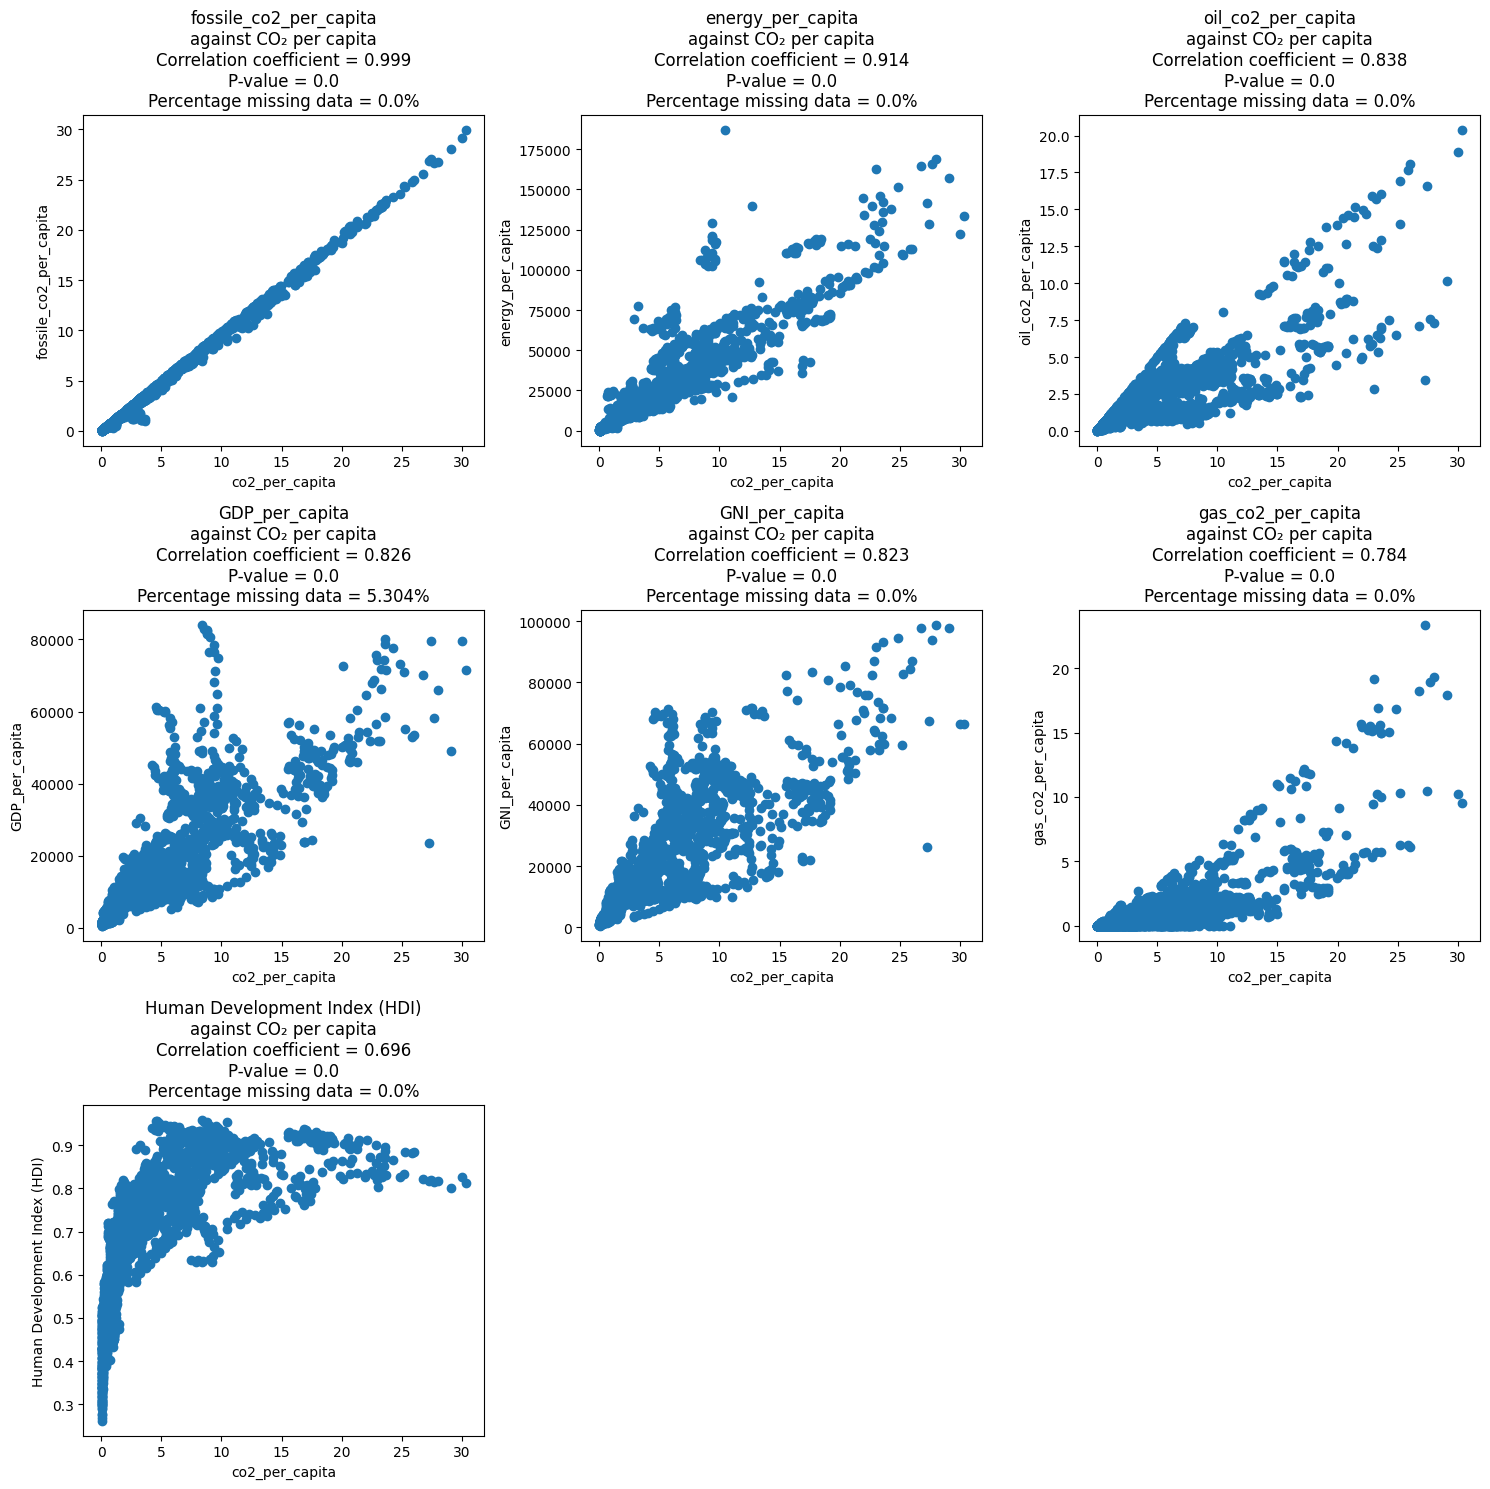

In [28]:
make_scatterplots(corr_threshold = 0.69, p_val_threshold = 0.05)

## **Conclusion**

In this study, we have examined the factors influencing a country's high CO₂ emissions per capita through a correlation analysis. We considered three different approaches for the analysis, with Approach 3 proving to be the most suitable. This involved an extensive dataset totaling 2300 rows, 170 countries, and 18 years (from 2000 to 2017).

Among the factors studied, the use of fossil fuels (gas, oil, and coal) emerged as the most significant predictor, with a remarkable correlation coefficient of 0.999. This coefficient surpassed the individual correlations of the three separate energy sources. This phenomenon could be attributed to the varying combinations of energy forms that different countries adopt.

In addition to fossil fuel usage, primary energy consumption per capita exhibited a substantial correlation (0.9138). Moreover, indicators of economic strength, such as Gross Domestic Product (GDP) per capita and Gross National Income (GNI) per capita, demonstrated strong predictive capabilities with correlation coefficients of 0.8259 and 0.8233, respectively.

The Human Development Index (HDI), a comprehensive measure of human development encompassing key dimensions like life expectancy, education access, and standard of living (measured by GNI), held a correlation coefficient of 0.6958.

In our study, several other predictors showed correlations, albeit less robust in comparison. It is noteworthy that the reliability of Pearson correlation coefficients is highest when variables follow a normal distribution and exhibit a linear relationship. However, in this analysis, the normality of the distribution was not investigated. In the case of the 'fossil energy' predictor, a very strong linear relationship is evident. As the linear relationship weakens for other predictors, the correlation coefficient also decreases.

In conclusion, the consumption of fossil fuels is the most significant predictor of high CO₂ emissions per capita. Economic and developmental factors also play a role.

## **References**

**CO₂ and Greenhouse Gas Emissions:**

Hannah Ritchie, Max Roser and Pablo Rosado (2020) - "CO₂ and Greenhouse Gas Emissions". Published online at OurWorldInData.org. Retrieved from: 'https://ourworldindata.org/co2-and-greenhouse-gas-emissions' [Online Resource]


**Food supply:**

Max Roser, Hannah Ritchie and Pablo Rosado (2013) - "Food Supply". Published online at OurWorldInData.org. Retrieved from: 'https://ourworldindata.org/food-supply' [Online Resource]

**Human Development Index (HDI)**

Max Roser (2014) - "Human Development Index (HDI)". Published online at OurWorldInData.org. Retrieved from: 'https://ourworldindata.org/human-development-index' [Online Resource]


**Interpretation Pierson correlation coefficients**
https://towardsdatascience.com/eveything-you-need-to-know-about-interpreting-correlations-2c485841c0b8
(credits to Parvez Ahammad)


**Functions for calculation correlation coefficient and p-values**
https://www.statology.org/p-value-correlation-pandas/


## **Appendix**

In [29]:
# Just curious...
# What is the difference between the unique countries in two different dataframes?

# Find the unique countries in each dataframe
countries_per_capita = df_CO2_per_capita['Country'].unique()
countries_data = df_CO2_data['Country'].unique()

# Find the countries that are in one dataframe but not in the other
countries_difference = set(countries_per_capita) ^ set(countries_data)

print("Countries in df_CO2_data but not in df_CO2_per_capita:")
for country in countries_difference:
    if country in countries_per_capita:
        print(f"- {country} (df_CO2_per_capita)")
    else:
        print(f"- {country} (df_CO2_data)")


Countries in df_CO2_data but not in df_CO2_per_capita:
- Ryukyu Islands (GCP) (df_CO2_data)
- Falkland Islands (df_CO2_data)
- Least developed countries (Jones et al. 2023) (df_CO2_data)
- Timor (df_CO2_per_capita)
- Faroe Islands (df_CO2_data)
- American Samoa (df_CO2_data)
- European Union (27) (GCP) (df_CO2_data)
- OECD (Jones et al. 2023) (df_CO2_data)
- Isle of Man (df_CO2_data)
- Panama Canal Zone (GCP) (df_CO2_data)
- Western Sahara (df_CO2_data)
- Kuwaiti Oil Fires (Jones et al. 2023) (df_CO2_data)
- OECD (GCP) (df_CO2_data)
- Svalbard and Jan Mayen (df_CO2_data)
- Kuwaiti Oil Fires (GCP) (df_CO2_data)
- Jersey (df_CO2_data)
- North America (GCP) (df_CO2_data)
- East Timor (df_CO2_data)
- Leeward Islands (Jones et al. 2023) (df_CO2_data)
- Oceania (GCP) (df_CO2_data)
- Panama Canal Zone (Jones et al. 2023) (df_CO2_data)
- Netherlands Antilles (df_CO2_data)
- Antarctica (df_CO2_data)
- Europe (GCP) (df_CO2_data)
- Non-OECD (GCP) (df_CO2_data)
- French West Africa (Jones et al. 2

In [30]:
# Just curious...
# Find all rows with values above 15 in the column 'co2_per_capita':
CO2_above_15 = df_all_from_1993.loc[df_all_from_1993['co2_per_capita'] >= 15]

# Unique countries in the column 'Country'
unique_countries = CO2_above_15['Country'].unique()
print(unique_countries)

# Unique years in the column 'Year'
unique_years = CO2_above_15['Year'].unique()
print(unique_years)

['Australia' 'Brunei' 'Canada' 'Kazakhstan' 'Kuwait' 'Luxembourg' 'Oman'
 'Saudi Arabia' 'Trinidad and Tobago' 'United Arab Emirates'
 'United States']
[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017]


In [31]:
# Just curious...
# Where the population density >= 5000????
# Find all rows with values above 5000 in the column 'Population density (people/km2)':
pd_above_5000 = df_all_from_1993.loc[df_all_from_1993['Population density (people/km2)'] >= 5000]

# Unique countries in the column 'Country'
unique_countries = pd_above_5000['Country'].unique()
print(unique_countries)

# Unique years in the column 'Year'
unique_years = pd_above_5000['Year'].unique()
print(unique_years)

['Hong Kong']
[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017]


In [32]:
# Just curious...
# Which are the countries where 'co2_per_capita' == 'oil_co2_per_capita'

df_countries_oil_co2_equal_co2 = df_all_from_1993[df_all_from_1993['co2_per_capita'] == df_all_from_1993['oil_co2_per_capita']]
df_countries_oil_co2_equal_co2
countries_unique = df_countries_oil_co2_equal_co2['Country'].unique().tolist()
print(countries_unique)

[]
